In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import json
import sys
import os
import shutil
from distutils.dir_util import copy_tree
# import imagesize
# import ptitprince as pt
from shutil import copyfile
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import seaborn as sns
import re
import xml.etree.ElementTree as ET 
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = "./PCB_DATASET/Annotations"

dataset = {
            "class":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "width":[],
            "height":[],
            "file":[],
            "defect_x_center":[],
            "defect_y_center":[],
            "defect_width":[],
            "defect_height":[],
            "image_width":[],
            "image_height":[],
            "category_codes":[]
           }
all_files = []

for path, subdirs, files in os.walk(dataset_path):
    print(path)
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))
        
        

for anno in all_files:
    # print(anno)
    tree = ET.parse(anno)
    
    
    cnt = 0
    for elem in tree.iter():
        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag: 
                    image_width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    image_height = int(round(float(attr.text)))

        if 'object' in elem.tag:
            cnt += 1
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                
                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['class']+=[name]
                    
                    if name == 'missing_hole':
                        dataset['category_codes'] += [1]
                    elif name == 'mouse_bite':
                        dataset['category_codes'] += [2]
                    elif name == 'open_circuit':
                        dataset['category_codes'] += [3]
                    elif name == 'short':
                        dataset['category_codes'] += [4]
                    elif name == 'spur':
                        dataset['category_codes'] += [5]
                    elif name == 'spurious_copper':
                        dataset['category_codes'] += [6]
                    
                    dataset['image_width']+=[image_width]
                    dataset['image_height']+=[image_height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    xmin = -1 
                    ymin = -1
                    xmax = -1
                    ymax = -1
                    for dim in list(attr):
                        #print('-', dim.tag)
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]
                    width = xmax - xmin
                    height = ymax - ymin
                    dataset['width'] += [width]
                    dataset['height'] += [height]
                    dataset['defect_x_center'] += [(((xmin + width) + xmin) / 2) / image_width]
                    if((((xmin + width) + xmin) / 2) / image_width >= 1):
                        print(xmin, ' + ', width, ' + ', xmin, ' / ', 2, ' / ', image_width)
                    dataset['defect_y_center'] += [(((ymin + height) + ymin) / 2) / image_height]
                    dataset['defect_width'] += [width / image_width]
                    dataset['defect_height'] += [height / image_height]

./PCB_DATASET/Annotations
./PCB_DATASET/Annotations\Missing_hole
./PCB_DATASET/Annotations\Mouse_bite
./PCB_DATASET/Annotations\Open_circuit
./PCB_DATASET/Annotations\Short
./PCB_DATASET/Annotations\Spur
./PCB_DATASET/Annotations\Spurious_copper


In [3]:
df = pd.DataFrame(dataset)
df['class'] = df['class'].replace({'missing_hole' : 2, 'mouse_bite' : 0, 'open_circuit' : 4, 'short' : 3, 'spur' : 1, 'spurious_copper' : 5})
df.head(10)

,class,xmin,ymin,xmax,ymax,width,height,file,defect_x_center,defect_y_center,defect_width,defect_height,image_width,image_height,category_codes
0,2,2459,1274,2530,1329,71,55,Annotations\Missing_hole\01_missing_hole_01,0.822182,0.820618,0.023401,0.034678,3034,1586,1
1,2,1613,334,1679,396,66,62,Annotations\Missing_hole\01_missing_hole_01,0.542518,0.230139,0.021753,0.039092,3034,1586,1
2,2,1726,794,1797,854,71,60,Annotations\Missing_hole\01_missing_hole_01,0.580587,0.519546,0.023401,0.037831,3034,1586,1
3,2,2584,232,2650,298,66,66,Annotations\Missing_hole\01_missing_hole_02,0.862558,0.167087,0.021753,0.041614,3034,1586,1
4,2,2366,803,2406,860,40,57,Annotations\Missing_hole\01_missing_hole_02,0.786421,0.524275,0.013184,0.035939,3034,1586,1
5,2,1506,802,1559,856,53,54,Annotations\Missing_hole\01_missing_hole_02,0.505109,0.522699,0.017469,0.034048,3034,1586,1
6,2,2651,487,2700,531,49,44,Annotations\Missing_hole\01_missing_hole_03,0.881839,0.320933,0.016150,0.027743,3034,1586,1
7,2,1342,749,1393,796,51,47,Annotations\Missing_hole\01_missing_hole_03,0.450725,0.487074,0.016809,0.029634,3034,1586,1
8,2,2082,582,2135,620,53,38,Annotations\Missing_hole\01_missing_hole_03,0.694957,0.378941,0.017469,0.023960,3034,1586,1
9,2,1619,225,1673,278,54,53,Annotations\Missing_hole\01_missing_hole_04,0.542518,0.158575,0.017798,0.033417,3034,1586,1


In [4]:
image_path = "./PCB_DATASET/images"
all_imgs = []

for path, subdirs, files in os.walk(image_path):
#     print([path, subdirs, files])
    for name in files:
        all_imgs.append(os.path.join(path, name))

print(all_imgs[1])
print(len(all_imgs))

./PCB_DATASET/images\Missing_hole\01_missing_hole_02.jpg
693


In [11]:
import shutil

history = df['file'][0].split("\\")[-1]
pointer = 0
myfile = ""

for entry in df.values:
    # print(history)
    filename = entry[7].split("\\")[-1]

    if(filename != history):
        imagename = entry[7].split("\\")[-1]
        file1 = open(f"train/labels/{history}.txt", "x")  # create mode
        file1.write(myfile)
        myfile = ""
        file1.close()
        shutil.copy(all_imgs[pointer], f"train/images")
        pointer += 1
        history = filename
    else:
        myfile += str(entry[0]) + " " + str(entry[8]) + " " + str(entry[9]) + " " + str(entry[10]) + " " + str(entry[11]) + "\n"

file1 = open(f"train/labels/{history}.txt", "x")  
file1.write(myfile)
file1.close()
shutil.copy(all_imgs[pointer], f"train/images")

'train/images\\12_spurious_copper_10.jpg'

In [30]:
for i in range(len(df), len(df)-5, -1):
    print(df['file'][i-1])

Annotations\Spurious_copper\12_spurious_copper_10
Annotations\Spurious_copper\12_spurious_copper_10
Annotations\Spurious_copper\12_spurious_copper_10
Annotations\Spurious_copper\12_spurious_copper_10
Annotations\Spurious_copper\12_spurious_copper_10


0.8221819380355966 0.8206179066834804 0.023401450230718525 0.03467843631778058 3034 1586
0.5425181278839816 0.23013871374527112 0.021753460777851022 0.03909205548549811 3034 1586
0.5805866842452209 0.519546027742749 0.023401450230718525 0.03783102143757881 3034 1586


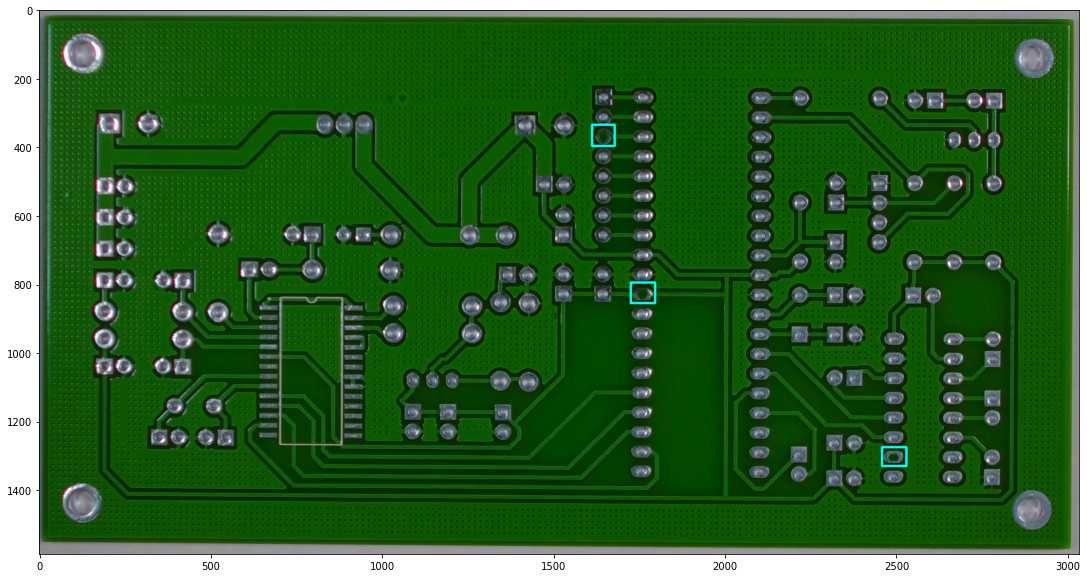

In [12]:
import cv2
import matplotlib.pyplot as plt 

img = cv2.imread(all_imgs[0])

for i in range(3):
    print(df['defect_x_center'][i], df['defect_y_center'][i], df['defect_width'][i], df['defect_height'][i], df['image_width'][i], df['image_height'][i])
    img_w = df['image_width'][i]
    img_h = df['image_height'][i]

    center_x = df['defect_x_center'][i]
    center_y = df['defect_y_center'][i]

    defect_w = df['defect_width'][i]
    defect_h = df['defect_height'][i]

    l = int((center_x - defect_w/2)* img_w)
    r = int((center_x + defect_w/2)* img_w)
    t = int((center_y - defect_h/2)* img_h)
    b = int((center_y + defect_h/2)* img_h)

    cv2.rectangle(img, (l,t), (r,b), (0,255,255), 5)


plt.figure(figsize=(20,10))
plt.imshow(img)